In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
'''------------------------Models libraries-------------------------'''
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
image_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/", "CXR_png")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/","masks/")

In [3]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [6]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

In [7]:
def Hist(image):
    H = np.zeros((256, 1))
    s = image.shape
    for i in range(s[0]):
        for j in range(s[1]):
            k = image[i, j]
            H[k, 0] = H[k, 0] + 1
    return H

In [8]:
def DHE(image):
    histg = Hist(image)
    s = image.shape
    x = histg.reshape(1, 256)
    y = np.array([])
    y = np.append(y, x[0, 0])

    for i in range(255):
        k = x[0, i + 1] + y[i]
        y = np.append(y, k)
    
    y = np.round((y / (s[0] * s[1])) * (256 - 1))
    for i in range(s[0]):
        for j in range(s[1]):
            k = image[i, j]
            image[i, j] = y[k]
    return image

In [9]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "test":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path, i))
            im = cv2.resize(im, shape)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            im = cv2.convertScaleAbs(im, alpha=1.3, beta=-20)
            im = DHE(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path, i))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "train":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path, i.split("_mask")[0] + ".png"))
            im = cv2.resize(im, shape)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            im = cv2.convertScaleAbs(im, alpha=1.3, beta=-20)
            im = DHE(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path, i + ".png"))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    # return list
    return im_array, mask_array

In [11]:
dim = 512
X_train, y_train = getData(dim, flag = "train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [02:33<00:00,  1.11s/it]


In [14]:
X_train = np.array(X_train).reshape(len(X_train), dim, dim, 1)
y_train = np.array(y_train).reshape(len(y_train), dim, dim, 1)
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)
y_test = np.array(y_test).reshape(len(y_test), dim, dim, 1)

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(566, 512, 512, 1) (566, 512, 512, 1)
(138, 512, 512, 1) (138, 512, 512, 1)


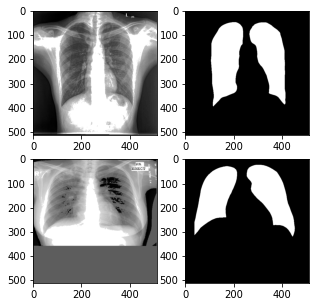

In [23]:
i = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axs[0, 0].imshow(X_train[i], cmap='gray')
axs[0, 1].imshow(y_train[i], cmap='gray')
axs[1, 0].imshow(X_test[i], cmap='gray')
axs[1, 1].imshow(y_test[i], cmap='gray');

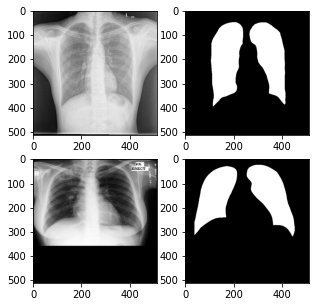

In [20]:
shape = (512, 512)

for i in testing_files:     
    imtest = cv2.imread(os.path.join(image_path, i))
    imtest = cv2.resize(imtest, shape)[:, :, 0]
    masktest = cv2.imread(os.path.join(mask_path, i))
    masktest = cv2.resize(masktest, shape)[:, :, 0]
    break
for i in training_files: 
    imtrain = cv2.imread(os.path.join(image_path, i.split("_mask")[0] + ".png"))
    imtrain = cv2.resize(imtrain, shape)[:, :, 0]
    masktrain = cv2.imread(os.path.join(mask_path, i + ".png"))
    masktrain = cv2.resize(masktrain, shape)[:, :, 0]
    break
'''----------------------------------------------------'''
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axs[0, 0].imshow(imtrain, cmap='gray')
axs[0, 1].imshow(masktrain, cmap='gray')
axs[1, 0].imshow(imtest, cmap='gray')
axs[1, 1].imshow(masktest, cmap='gray');

In [24]:
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train, X_test), axis=0)
masks  = np.concatenate((y_train, y_test), axis=0)

In [25]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [37]:
metrics = [dice_coef, 'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

In [38]:
model = unet(input_size=(512, 512, 1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [39]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [40]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=35) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [41]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_val, Y_train, Y_val = train_test_split((images-127.0)/127.0, 
                                                  (masks>127).astype(np.float32), 
                                                  test_size = 0.1, 
                                                  random_state = 2018)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, 
                                                    test_size = 0.1, 
                                                    random_state = 2018)

In [42]:
model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
              metrics = metrics)

In [43]:
loss_history = model.fit(X_train, Y_train,
                         batch_size = 16, epochs = 80,
                         validation_data = (X_val, Y_val),
                         callbacks=callbacks_list)

Epoch 1/80
36/36 [==============================] - 21s 539ms/step - loss: -0.3692 - dice_coef: 0.3693 - binary_accuracy: 0.5673 - precision_1: 0.3498 - recall_1: 0.8035 - val_loss: -0.5512 - val_dice_coef: 0.5530 - val_binary_accuracy: 0.6975 - val_precision_1: 0.4283 - val_recall_1: 0.7745

Epoch 00001: val_loss improved from inf to -0.55125, saving model to cxr_reg_weights.best.hdf5
Epoch 2/80
36/36 [==============================] - 19s 518ms/step - loss: -0.5784 - dice_coef: 0.5784 - binary_accuracy: 0.6953 - precision_1: 0.4393 - recall_1: 0.8474 - val_loss: -0.5818 - val_dice_coef: 0.5830 - val_binary_accuracy: 0.7044 - val_precision_1: 0.4407 - val_recall_1: 0.8569

Epoch 00002: val_loss improved from -0.55125 to -0.58178, saving model to cxr_reg_weights.best.hdf5
Epoch 3/80
36/36 [==============================] - 19s 518ms/step - loss: -0.5628 - dice_coef: 0.5629 - binary_accuracy: 0.6363 - precision_1: 0.4068 - recall_1: 0.8464 - val_loss: -0.7097 - val_dice_coef: 0.7100 - v

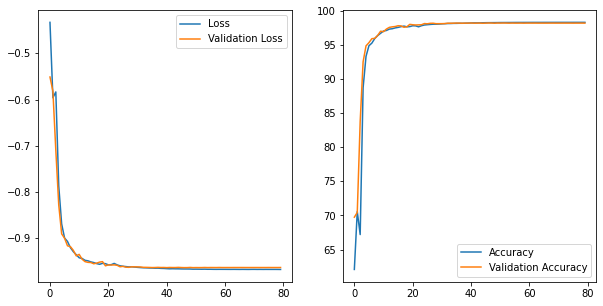

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

In [46]:
pred_candidates = np.random.randint(1, X_test.shape[0], 10)
preds = model.predict(X_test)

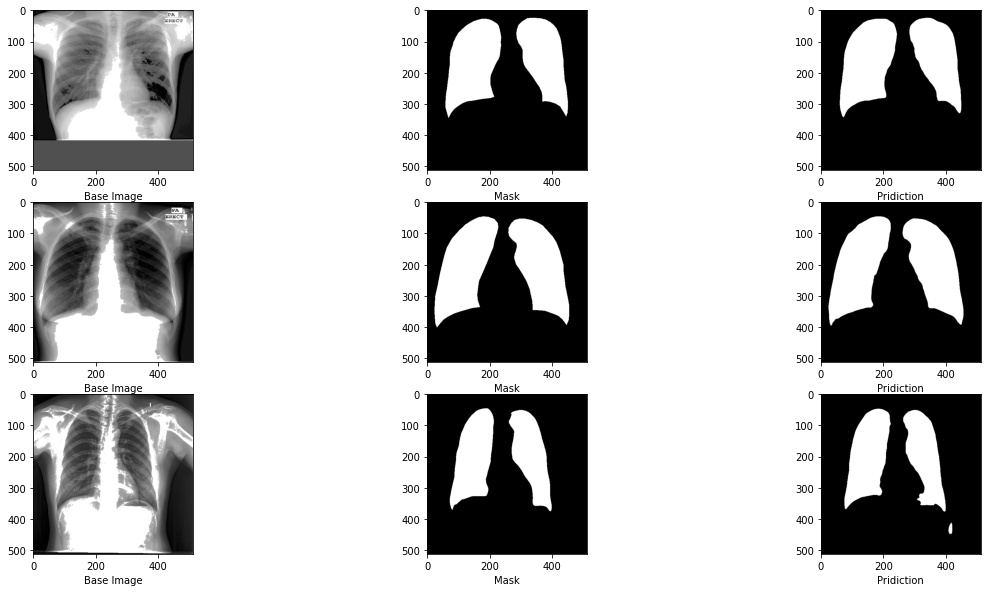

In [47]:
plt.figure(figsize=(20, 10))

for i in range(0, 9, 3):
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(np.squeeze(X_test[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Base Image")
    
    
    plt.subplot(3, 3, i + 2)
    plt.imshow(np.squeeze(Y_test[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Mask")
    
    plt.subplot(3, 3, i + 3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Pridiction")

In [52]:
# model.evaluate(X_val, Y_val)

In [48]:
model.evaluate(X_test, Y_test)

2/2 [==============================] - 2s 291ms/step - loss: -0.9652 - dice_coef: 0.9652 - binary_accuracy: 0.9820 - precision_1: 0.9668 - recall_1: 0.9636


[-0.9651949405670166,
 0.9651949405670166,
 0.9819878935813904,
 0.9668424129486084,
 0.9636437296867371]

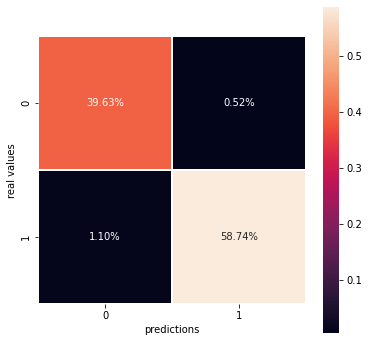

In [58]:
    import seaborn as sns

    FP = len(np.where(preds - Y_test  == -1)[0])
    FN = len(np.where(preds - Y_test  == 1)[0])
    TP = len(np.where(preds + Y_test ==2)[0])
    TN = len(np.where(preds + Y_test == 0)[0])
    cmat = [[TP, FN], [FP, TN]]

    plt.figure(figsize = (6,6))
    sns.heatmap(cmat / np.sum(cmat), annot=True, fmt = '.2%', square=1,   linewidth=2.)
    plt.xlabel("predictions")
    plt.ylabel("real values")
    plt.show()

In [60]:
Acc = (TP + TN) / (TP + FP + FN + TN)
Recall = TP / (TP + FN)
Precision = TP / (TP + FP)
Jaccard = TP / (TP + FP + FN)
F1_Score = (2 * Precision * Recall) / (Precision + Recall)
print(f'Acc = {Acc}')
print(f'Recall = {Recall}')
print(f'Precision = {Precision}')
print(f'Jaccard = {Jaccard}')
print(f'F1_Score = {F1_Score}')

Acc = 0.9837659966859829
Recall = 0.9870123545566591
Precision = 0.9729507784397805
Jaccard = 0.9606519211903884
F1_Score = 0.9799311247527701
